In [1]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
# Aplicação do HDBSCAN
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

/home/grad/si/24/guilherme.evangelista/anaconda3/envs/condaclustering/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-08 23:15:26.986000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 23:15:26.996331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 23:15:26.999459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 23:15:27.008323: I tensorflow/core/platform/cpu_fe

In [13]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5","exams_part12.hdf5", "exams_part13.hdf5", "exams_part10.hdf5", "exams_part11.hdf5","exams_part9.hdf5", "exams_part8.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == True) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 9] == False)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == True) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == False) & 
                                (dados.iloc[:, 9] == False)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:10000]

ids_ecgs= ecg_doente_id + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 73700
Número de linhas ecg_doente_linhas: 2581
Tirando Interferência:
Número de linhas ecg_normal_linhas: 71713
Número de linhas ecg_doente_linhas: 2544
Número de ecgs pra clusterizar: 12544


In [14]:
# Função para obter dados de ECG de um arquivo HDF5
def get_ecg_data(file_paths, exam_id):
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) != 0:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings
    raise ValueError("Exam ID não encontrado em nenhum dos arquivos fornecidos.")

# Caminhos para os arquivos HDF5
file_paths = ['../Database/filtered_exams_14_15.hdf5', '../Database/filtered_exams_16_17.hdf5','../Database/filtered_exams_12_13.hdf5', '../Database/filtered_exams_10_11.hdf5','../Database/filtered_exams_8_9.hdf5']

# Obter os tracings de ECG para cada exam_id e armazenar na lista
all_tracings = []
for exam_id in ids_ecgs:
    tracings = get_ecg_data(file_paths, exam_id)
    # Selecionar as leads V1 (índice 6) e V6 (índice 11)
    lead_v1 = tracings[:, 6]
    lead_v6 = tracings[:, 9]
    #lead_d2 = tracings[:, 1]
    #lead_d1 = tracings[:, 0]
    #Combinar as leads V1 e V6 em uma única dimensão
    combined_leads = np.concatenate((lead_v1, lead_v6))
    all_tracings.append(combined_leads)

# Converter lista para array numpy
X = np.array(all_tracings)

print("Shape de X para o autoencoder:", X.shape)

# X agora está pronto para ser usado no autoencoder

Shape de X para o autoencoder: (12544, 8192)


In [57]:
from sklearn.model_selection import train_test_split


autoencoder = tf.keras.models.load_model('modelos/autoencoder_model_D2V1V6.keras')
# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test[idx]

# Reconstruir o ECG usando o autoencoder
reconstructed_ecg = autoencoder.predict(np.expand_dims(original_ecg, axis=0))

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()


ValueError: Input 0 of layer "autoencoder" is incompatible with the layer: expected shape=(None, 12288, 1), found shape=(1, 8192)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# Definir a arquitetura do autoencoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.conv2 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.conv3 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.conv4 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.conv5 = nn.Conv1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7)
        self.conv6 = nn.Conv1d(in_channels=20, out_channels=1, kernel_size=16, stride=2, padding=7)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        x = self.conv6(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose1d(in_channels=1, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.deconv2 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.deconv3 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.deconv4 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.deconv5 = nn.ConvTranspose1d(in_channels=20, out_channels=20, kernel_size=16, stride=2, padding=7, output_padding=0)
        self.deconv6 = nn.ConvTranspose1d(in_channels=20, out_channels=1, kernel_size=16, stride=2, padding=7, output_padding=0)

    def forward(self, x):
        x = F.elu(self.deconv1(x))
        x = F.elu(self.deconv2(x))
        x = F.elu(self.deconv3(x))
        x = F.elu(self.deconv4(x))
        x = F.elu(self.deconv5(x))
        x = self.deconv6(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instanciar o modelo
autoencoder = Autoencoder()

In [6]:
#DIMINUIR DIMENSAO DE X PYTORCH PELO AUTOENCODER(128)

 #Carregar os pesos salvos
model_path = 'modelos/best_autoencoder.pth'
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()  # Colocar o modelo em modo de avaliação

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.encoder

# Carregar os dados (este é um exemplo, você deve carregar seus dados reais)
# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# X = np.load('seu_arquivo_de_dados.npy')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Converter os dados para um tensor PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)

# Obter os vetores codificados para todo o conjunto X
with torch.no_grad():
    X_encoded = encoder(X_tensor).numpy()

print("Forma da saída do encoder antes de remover a dimensão extra:", X_encoded.shape)

if X_encoded.shape[1] == 1:
    X_encoded_2d = X_encoded.squeeze(1)


# Verificar a forma final
print("Forma final da saída do encoder:", X_encoded_2d.shape)  # Deve ser (13748, 128)

/tmp/ipykernel_404092/163475440.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(model_path))


Forma da saída do encoder antes de remover a dimensão extra: (23748, 1, 128)
Forma final da saída do encoder: (23748, 128)


In [15]:
#DIMINUIR DIMENSAO DE X TENSORFLOW PELO AUTOENCODER(128)

# Carregar o modelo autoencoder
autoencoder = tf.keras.models.load_model('modelos/autoencoder_model_LBBB.keras')

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Carregar os dados (este é um exemplo, você deve carregar seus dados reais)
# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# X = np.load('seu_arquivo_de_dados.npy')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

392/392 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
(12544, 128, 1)
(12544, 128)


In [16]:
epsilon = 1e-10
# Substituir valores NaN por epsilon
X_encoded_2d = np.nan_to_num(X_encoded_2d, nan=epsilon)
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)

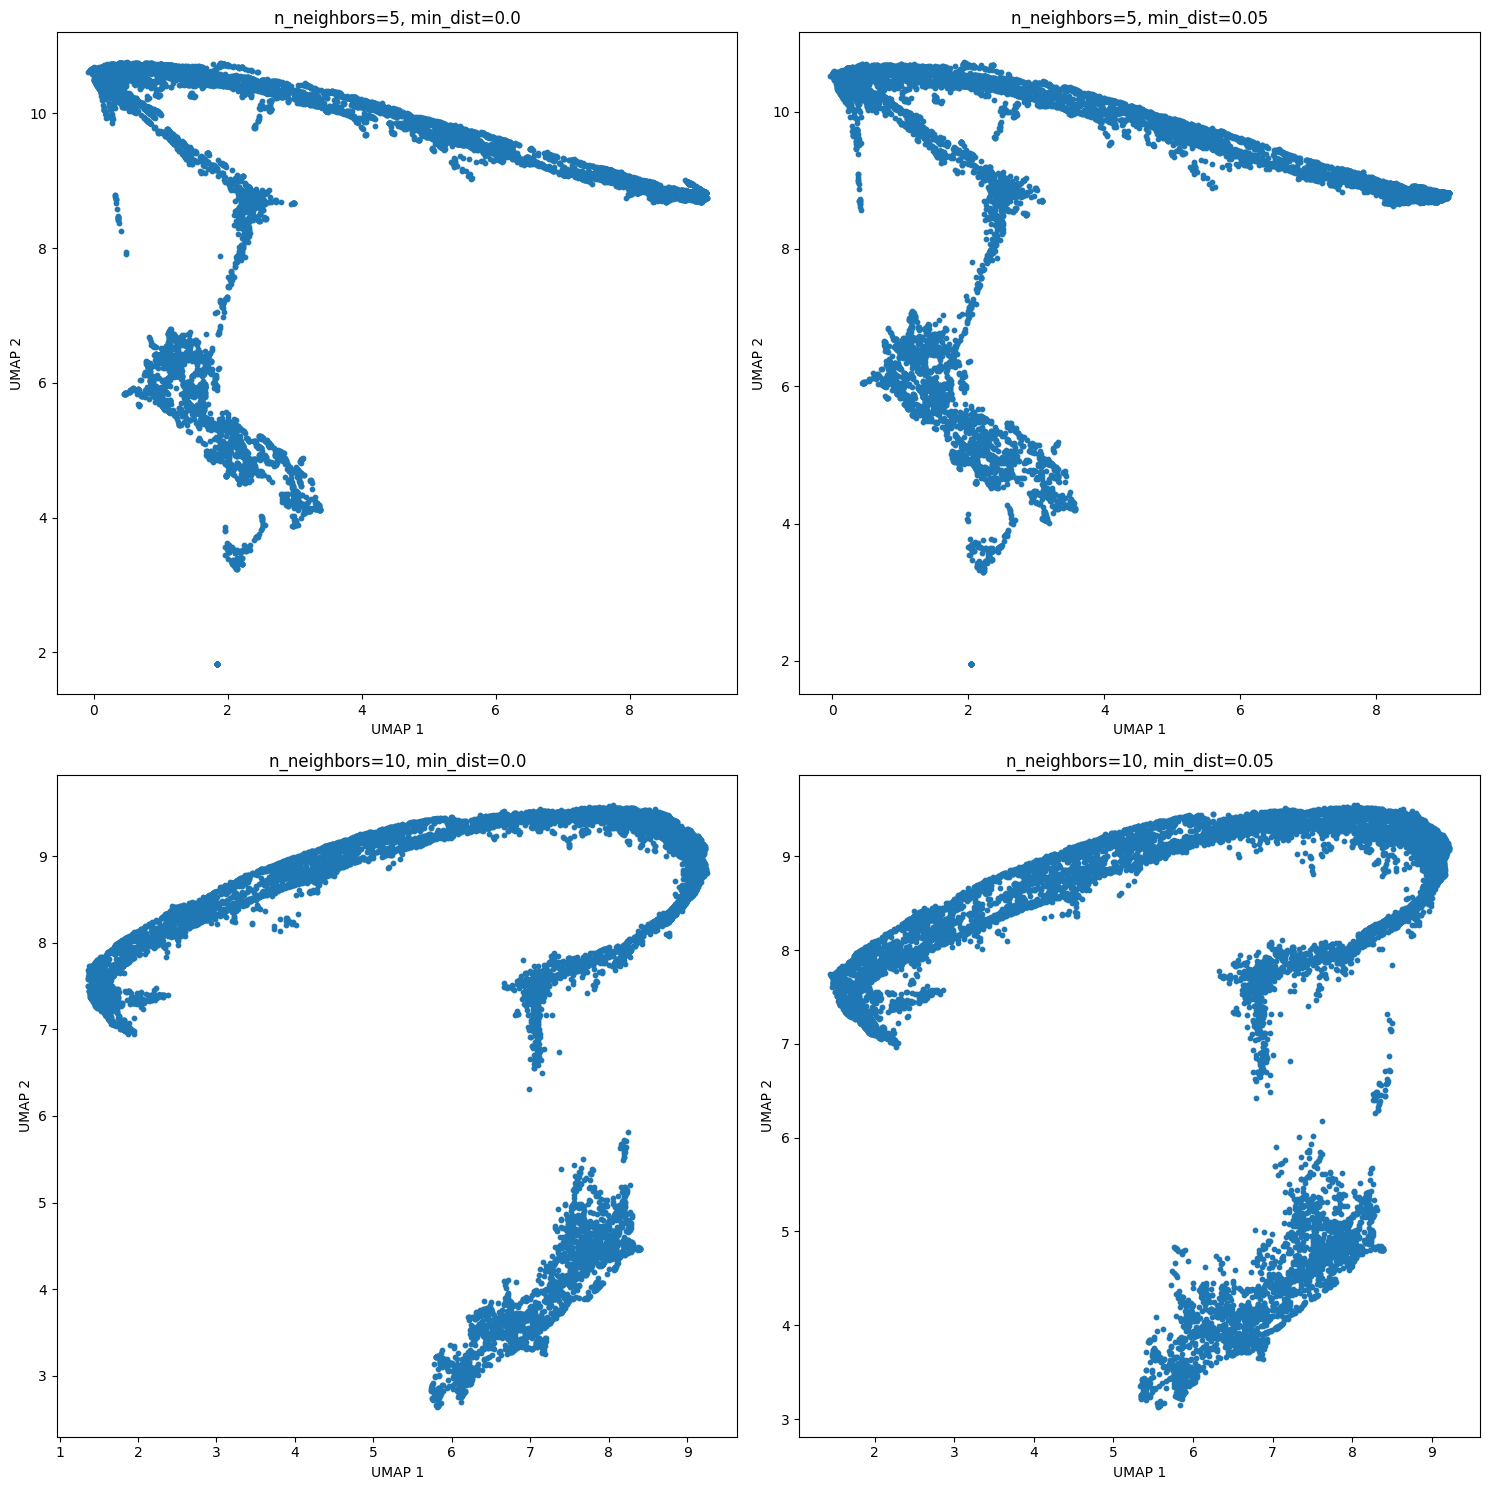

In [17]:
import umap.plot
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")


# Definir os parâmetros a serem testados
n_neighbors_list = [5, 10]
min_dist_list = [0.0, 0.05]

# Criar subplots
fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 15))

# Iterar sobre os parâmetros e gerar os subplots
for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=16, random_state=42)
        X_reduced = umap_reducer.fit_transform(X_normalized)
        
        ax = axes[i, j]
        ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=10)
        ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        
# Ajustar layout
plt.tight_layout()
plt.show()


In [18]:
umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0.00, n_components=16, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

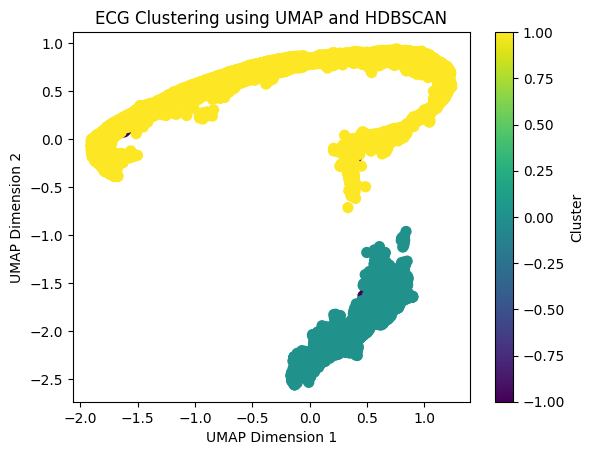

Silhouette Score: -0.011380482465028763
   cluster  1dAVb  RBBB  LBBB  SB  ST  AF  normal_ecg
0       -1      0     0     4   0   0   0          11
1        0      0     0  2337   0   0   0         102
2        1      0     0   203   0   0   0        9887


In [19]:
#CLUSTERIZACAO HDBSCAN
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=1000, min_samples=5)
labels = dbscan.fit_predict(X_reduced_scaled)
# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN')
plt.colorbar(label='Cluster')
plt.show()
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')


# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': ids_ecgs,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

In [ ]:
#TENTAR PREVER O TREINO NOS CLUSTERS
# Normalizar os dados
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)
new_data_scaled = scaler.transform(X_TREINO_reduced)

# Treinar o modelo HDBSCAN com prediction_data=True
dbscan = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=5, prediction_data=True)
labels = dbscan.fit_predict(X_reduced_scaled)

# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN')
plt.colorbar(label='Cluster')
plt.show()

# Calcular Silhouette Score
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Para predizer novos dados
new_data = new_data_scaled # Certifique-se de que seus novos dados estão normalizados corretamente

# Usar approximate_predict para prever os rótulos dos novos dados
try:
    new_labels, new_probabilities = hdbscan.approximate_predict(dbscan, new_data)
except AttributeError as e:
    print("Erro na previsão: ", e)
    new_labels = np.array([])

# Configurar para mostrar todos os elementos no print
np.set_printoptions(threshold=np.inf)

print("New labels:", new_labels)
print("New probabilities:", new_probabilities)